In [1]:
import torch
from glob import glob
from ast import literal_eval
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from IPython.core.display import display, HTML
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from time import time

In [2]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

plt.style.use('dark_background')

display(HTML("<style>"
    + "#notebook { padding-top:0px; } " ""
    + ".container { width:100%; } "
    + ".end_space { min-height:0px; } "
    + "</style>"))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [3]:
def calc_euclid_dist(data: torch.Tensor):
    return ((data.unsqueeze(0) - data.unsqueeze(1)) ** 2).sum(-1)

def calc_ADL_knn(distances: torch.Tensor, k: int, symmetric: bool = True):
    new_A = torch.clone(distances)
    new_A[torch.eye(len(new_A)).bool()] = +torch.inf

    final_A = torch.zeros_like(new_A)
    idxes = new_A.topk(k, largest=False)[1]
    final_A[torch.arange(len(idxes)).unsqueeze(1), idxes] = 1
    final_A = ((final_A + final_A.T) > 0).float()
    A = final_A.detach()
    # compute degree matrix
    d_values = A.sum(1)
    assert not (d_values == 0).any(), f'D contains zeros in diag: \n{d_values}'  # \n{A.tolist()}\n{distances.tolist()}'
    D = torch.diag(d_values)
    # compute laplacian
    L = D - A
    return A, D, L

def get_knn(data: torch.Tensor, k=10) -> torch.Tensor:
    distances = calc_euclid_dist(data)
    A, D, L = calc_ADL_knn(distances, k, symmetric=True)
    return A

In [4]:
def get_name_exp(exp: dict):
    interesting_props = ['diag_weight', 'use_pm_dataset_buffer']
    props = {}
    for prop in interesting_props:
        if prop in exp:
            props[prop] = exp[prop]
    if len(props) == 0: props = ''
    return f'{exp["model"]} {props}'

def print_exp_info(exp: dict):
    print(f'model: {get_name_exp(exp)}')
    print({k: exp[k] for k in exp if k not in ['latents', 'results']})

In [5]:
logs_path = '/nas/softechict-nas-1/rbenaglia/data'

In [6]:
exp_list = []
environments = []
for log_file in glob(logs_path + '/**/*res2*.pyd', recursive=True):
    print(log_file)
    with open(log_file, 'r') as f:
        props_list = [prop for prop in log_file.replace(logs_path, '').split('/')[1:]]
        print(f'Env: {props_list}')
        props = props_list
        exps = []
        for i, line in enumerate(f.readlines()):
            try:
                exps.append(literal_eval(line.replace('nan', 'None')))
            except:
                print(f'Unparsed line {i}:\n\t{exps[:-1]}\n-->\t{line}')

        environments.append({'env': props, 'exps': exps})

        exp_list.extend(exps)

/nas/softechict-nas-1/rbenaglia/data/spectral_features2.pyd
Env: ['spectral_features2.pyd']


### Result format
exp['results'] -> array[2 tasks] of object {'feat_buf': list[1000], 'y_buf': list[1000]}

In [39]:
def knn_errors(knn: torch.Tensor, labels: torch.Tensor):
    n = len(labels)
    perfect = torch.zeros_like(knn)
    for i, gt in enumerate(labels):
        perfect[i] = (labels == gt).int()
    perfect[torch.eye(n).bool()] = 0
    # sns.heatmap(perfect.cpu(), cmap='binary', vmin=0, vmax=1, cbar=False, xticklabels=False, yticklabels=False)
    # plt.show()
    return (perfect - knn).abs().sum().item()

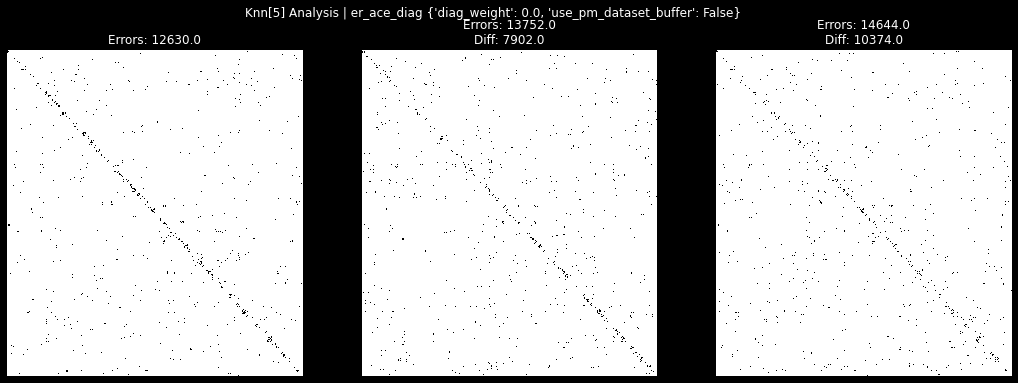

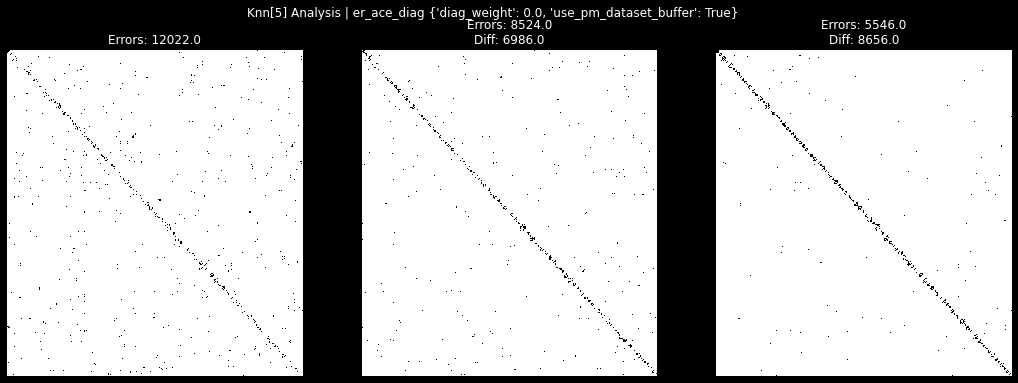

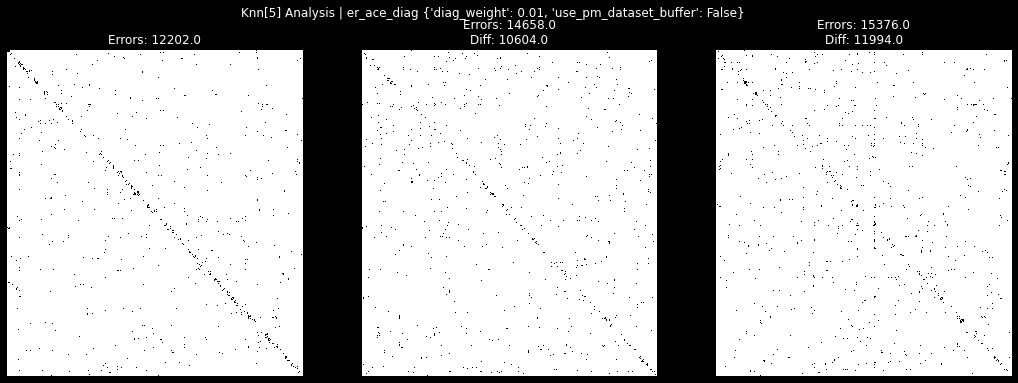

In [40]:
@torch.no_grad()
def knn_diff(exp: dict, k=5):
    # print_exp_info(exp)
    labels = torch.tensor(exp['results'][0]['y_buf']).to(device)
    data1 = torch.tensor(exp['results'][0]['feat_buf']).to(device)
    data2 = torch.tensor(exp['results'][1]['feat_buf']).to(device)
    data3 = torch.tensor(exp['results'][2]['feat_buf']).to(device)
    sorter = labels.argsort()

    knn1 = get_knn(data1[sorter], k)
    knn2 = get_knn(data2[sorter], k)
    knn3 = get_knn(data3[sorter], k)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    plt.suptitle(f'Knn[{k}] Analysis | {get_name_exp(exp)}')

    errors = knn_errors(knn1, labels[sorter])
    sns.heatmap(knn1.cpu(), cmap='binary', vmin=0, vmax=1, ax=ax[0], cbar=False, xticklabels=False, yticklabels=False)
    ax[0].set_title(f'Errors: {errors}')

    errors = knn_errors(knn2, labels[sorter])
    diff = (knn2 - knn1).abs().sum().item()
    sns.heatmap(knn2.cpu(), cmap='binary', vmin=0, vmax=1, ax=ax[1], cbar=False, xticklabels=False, yticklabels=False)
    ax[1].set_title(f'Errors: {errors}\nDiff: {diff}')

    errors = knn_errors(knn3, labels[sorter])
    diff = (knn3 - knn1).abs().sum().item()
    sns.heatmap(knn3.cpu(), cmap='binary', vmin=0, vmax=1, ax=ax[2], cbar=False, xticklabels=False, yticklabels=False)
    ax[2].set_title(f'Errors: {errors}\nDiff: {diff}')
    plt.show()

for exp in exp_list:
    knn_diff(exp)
